#Preprocessing steps to clean up dataset

###Combine Post and Title into a new column in the dataset

In [ ]:
!pip install redditcleaner
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify output directory based on location of script

# output dir if drive has been mounted:
output_dir = '/content/drive/My Drive/685/Project/'

In [ ]:
import pandas as pd

df = pd.read_csv(output_dir + 'data/final_dataset_uncombined.csv')
df['content'] = df['title'] + ' ' + df['post']

In [ ]:
print(df.shape)

(9720, 4)


no mental illness    1826
autism               1031
bpd                  1010
adhd                  996
bipolar               934
anxiety               926
psychosis             815
depression            754
suicidal              730
schizophrenia         698
Name: label, dtype: int64


<Axes: xlabel='count', ylabel='label'>

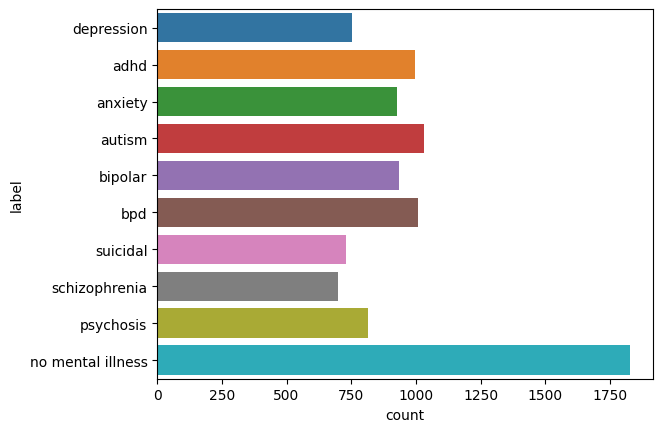

In [ ]:
import seaborn as sb

print(df['label'].value_counts())
sb.countplot(y="label", data=df)

###Remove duplicates from the dataset to eliminate reposts from multiple users

In [ ]:
#Remove Duplicates
df = df.drop_duplicates(subset='content')
print(df.shape)

(9667, 4)


###Check for missing values

In [ ]:
# Check if there are any missing values 
# Output: False = No missing values
df.isnull().any()

label      False
post       False
title      False
content    False
dtype: bool

###Remove leading and trailing extra spaces from content

In [ ]:
# Remove extra spaces 
df['title'] = df['title'].str.strip()
df['post'] = df['post'].str.strip()
df['content'] = df['content'].str.strip()

###Cleanup Markdown and HTML formatting from the data

In [ ]:
# Remove specific characters from Reddit markdown formatting with reddit cleaner 
import redditcleaner
df['title'] = df['title'].map(redditcleaner.clean)
df['post'] = df['post'].map(redditcleaner.clean)
df['content'] = df['content'].map(redditcleaner.clean)

###Replace emojis with text description

In [ ]:
#Check for emojis in the posts
emoji_result = df['content'].apply(lambda x: demoji.findall(x))
for item in emoji_result.tolist():
    if  item:
        print(item)

{'🙂': 'slightly smiling face'}
{'😭': 'loudly crying face'}
{'😞': 'disappointed face'}
{'😔': 'pensive face', '😖': 'confounded face', '🙏': 'folded hands'}
{'💚': 'green heart'}
{'🙏🏾': 'folded hands: medium-dark skin tone', '😭': 'loudly crying face'}
{'😥': 'sad but relieved face'}
{'❤️': 'red heart'}
{'🥲': 'smiling face with tear', '😄': 'grinning face with smiling eyes', '🙂': 'slightly smiling face', '💔': 'broken heart', '😅': 'grinning face with sweat'}
{'💀': 'skull'}
{'🌈': 'rainbow'}
{'💔': 'broken heart'}
{'👀': 'eyes'}
{'😞': 'disappointed face', '🌼': 'blossom', '💯': 'hundred points'}
{'😆': 'grinning squinting face', '🎉': 'party popper', '🤷\u200d♀️': 'woman shrugging'}
{'😭': 'loudly crying face'}
{'👀': 'eyes'}
{'🥲': 'smiling face with tear'}
{'❤️': 'red heart'}
{'❤️': 'red heart'}
{'😊': 'smiling face with smiling eyes'}
{'✨': 'sparkles'}
{'😭': 'loudly crying face', '✨': 'sparkles'}
{'😅': 'grinning face with sweat'}
{'✌️': 'victory hand'}
{'💀': 'skull'}
{'🤣': 'rolling on the floor laughing'

In [ ]:
# Function to remove emojis 
import demoji

# initialize demoji library
demoji.download_codes()
def replace_emoji_with_inferred_text(text):
  # replace emojis with their descriptions
  text_without_emojis = demoji.replace_with_desc(text)

  # remove any extra characters (e.g., colons)
  text_without_emojis = text_without_emojis.replace(':', ' ')
  return text_without_emojis

<ipython-input-46-9cdb83ec5b65>:5: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [ ]:
#Test to see if emoji replacement works
print(replace_emoji_with_inferred_text('This game is 🔥🔥'))

This game is  fire  fire 


In [ ]:
#Apply emoji replacement to all post contents
df['content'] = df['content'].apply(lambda x: replace_emoji_with_inferred_text(x))

###Remove URL's from Post content

In [ ]:
# Remove urls 
df['content'] = df['content'].str.replace('http\S+|www.\S+', '', case=False)

<ipython-input-51-371dd464e8a9>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['content'] = df['content'].str.replace('http\S+|www.\S+', '', case=False)


###Remove posts made by bots

In [ ]:
df = df[~df.content.str.contains('(?i)bot')] ## ~1000 posts removed
print(df.shape)

(8690, 4)


###Remove quoted and referenced texts

In [ ]:
df = df[~df.content.str.contains('(?i)quote')] ## ~ 25 posts removed
print(df.shape)

(8665, 4)


### Remove additional reddit formatting not covered by redditcleaner

In [ ]:
import re

def reddit_specific_preprocessing(text):
    
    # Table
    text = re.sub(r'\|', ' ', text)
    text = re.sub(':-', '', text)

    # Remove asterisk
    text = re.sub(r'\*', '', text)

    # Remove bullet points
    text = re.sub('&amp;#x200B;', '', text)

    # Remove strikethroughs
    text = re.sub('~', '', text)

    # Remove spoilers, which is used with < less-than (Preserves the text)
    text = re.sub('&lt;', '', text)
    text = re.sub(r'!(.*?)!', r'\1', text)

    # Remove newlines (one or more)
    text = re.sub(r'\n+', ' ', text)

    # Remove quotes
    text = re.sub(r'\"?\\?&?gt;?', '', text)

    # Code, inline and block
    text = re.sub('`', '', text)

    # Remove links (always enclosed between parenthesis)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    # Superscript (Preserves the text)
    text = re.sub(r'\^\((.*?)\)', r'\1', text)

    # Clean white spaces
    text = text.strip()
    text = re.sub(r'\s\s+', ' ', text)

    # Heading
    text = re.sub('#', '', text)
    
    return text

In [ ]:
df['content'] = df['content'].apply(lambda text: reddit_specific_preprocessing(text))

In [ ]:
df.to_csv(output_dir + '/data/final_dataset_combined.csv')

### Post pre-processing counts by class

In [ ]:
print(df['label'].value_counts())

no mental illness    1575
autism                909
adhd                  874
bpd                   869
bipolar               857
anxiety               846
psychosis             743
depression            679
schizophrenia         657
suicidal              656
Name: label, dtype: int64


<Axes: xlabel='count', ylabel='label'>

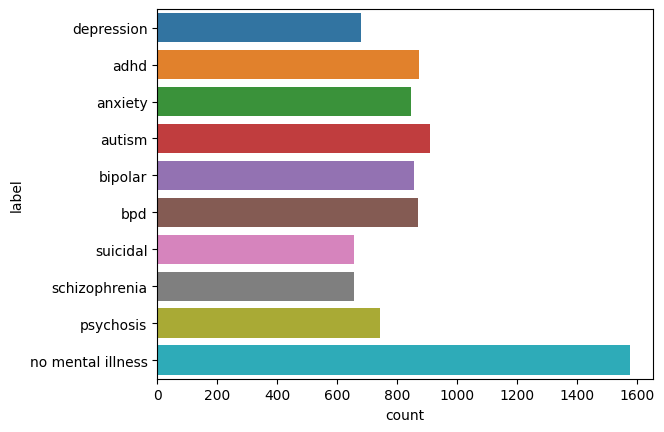

In [ ]:
import seaborn as sb
sb.countplot(y="label", data=df)